In [1]:
%load_ext autoreload
%autoreload 2

import torch
from dataset import CamerasDataset,OctantDataset
from sh import to_spherical,calc_sh

In [2]:
ds = CamerasDataset("../datasets/bunny/octants")

loading dataset: 100%|██████████| 1/1 [00:00<00:00, 26.83it/s]


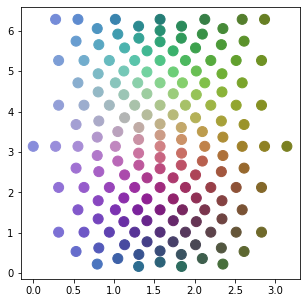

In [5]:
from matplotlib import pyplot as plt 

pos,color,vertex_pos,vertex_color,coefs = ds[0]

sp = to_spherical(pos)
plt.figure(figsize=(5,5))
plt.scatter(sp[:,0],sp[:,1],c=color[:,:3].float()/255,s=100)

In [ ]:

res = 100

x = torch.arange(0, 1, 1 / res)
grid_x, grid_y = torch.meshgrid(x * torch.pi, x * 2 * torch.pi, indexing="ij")
coords = torch.stack((grid_x.flatten(), grid_y.flatten())).T

y = calc_sh(10, coords)
plt.imshow((y@coefs).reshape((res,res,-1)).permute(1,0,2))
plt.scatter(sp[:,0]*res/(torch.pi),sp[:,1]*res/(2*torch.pi),c=color[:,:3].float()/255,s=100)#,edgecolors='black')

In [ ]:
colors= torch.stack([vertex_color.float().mean(0)/255 for _,_,_,vertex_color,_ in ds])
plt.imshow(colors[:400].reshape(20,20,4))

In [ ]:
colors= torch.stack([cam_colors.float().mean(0)/255 for _,cam_colors,_,_,_ in ds])
plt.imshow(colors[:400].reshape(20,20,4)[:,:,:3])

In [6]:
#colors_std = torch.tensor([coefs[1:].std().item() for  _,colors,_,_,coefs in ds])
colors_std = torch.tensor([(colors.float()/255)[:,:3].var(0).max().item() for  _,colors,_,_,coefs in ds])
colors_std.shape

torch.Size([811798])

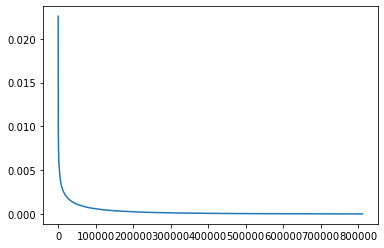

In [20]:
values,indices = colors_std.sort(dim=0,descending=True)
plt.plot(values)

In [21]:
torch.save(indices,"../datasets/neuschwanstein/octants_1024max_var_sorted.pt")

In [19]:
indices.shape

torch.Size([64])

In [22]:
selected_indices = torch.load(
        "../datasets/neuschwanstein/octants_1024max_var_sorted.pt"
    )[:100000]
selected_indices.shape

torch.Size([100000])

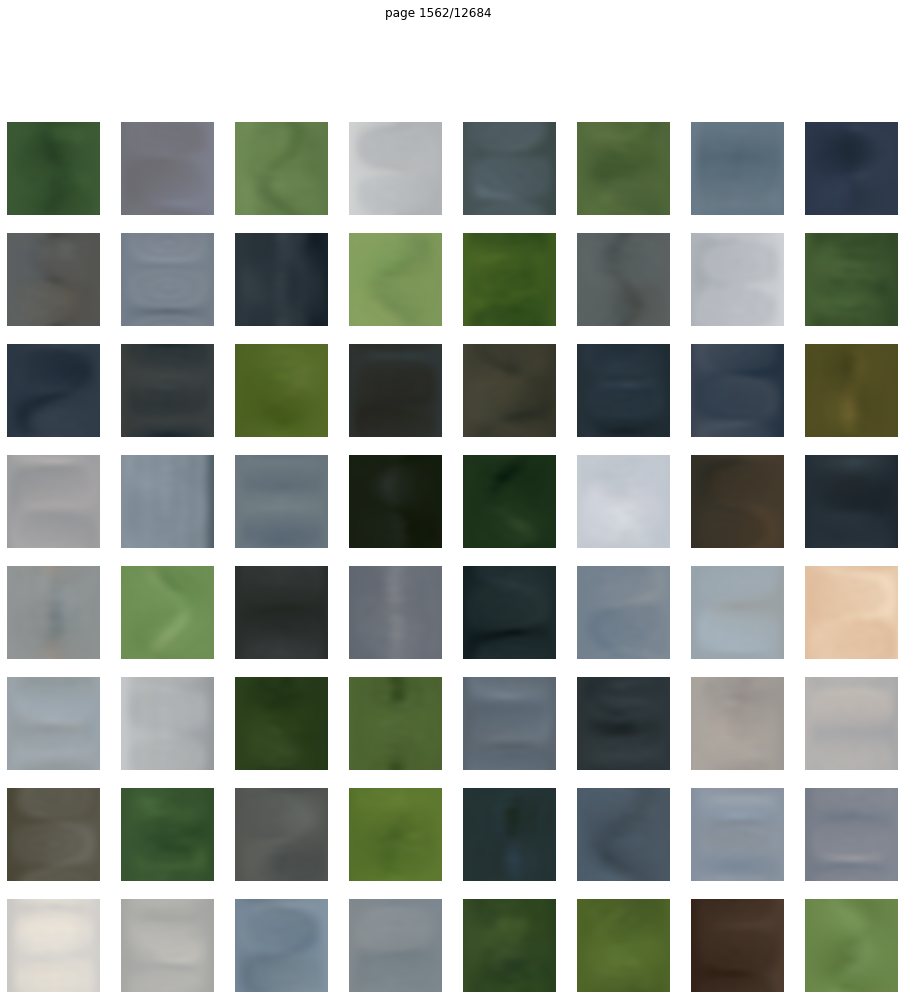

In [15]:
from sh import calc_sh

n = 8*8
page = 100000 // n
lmax = 10
values,indices = colors_std.topk(n*page)
values=values[n*(page-1):]
indices=indices[n*(page-1):]

res = 100

x = torch.arange(0, 1, 1 / res)
grid_x, grid_y = torch.meshgrid(x * torch.pi, x * 2 * torch.pi, indexing="ij")
coords = torch.stack((grid_x.flatten(), grid_y.flatten())).T

y = calc_sh(lmax, coords)


fig, axes = plt.subplots(n//8, 8, figsize=(16, n//8*2))
#fig.tight_layout()
fig.suptitle(f"page {page}/{len(colors_std)//n}")

for i in range(n):
    ax = axes[i//8][i%8]
    ax.set_axis_off()
    # ax.set_title(ds.ply_files[indices[i]].split("/")[-1])
    #ax.set_title(colors_std[indices[i]].item().round())
    target = (y @ ds[indices[i]][4]).reshape(res, res, -1)
    ax.imshow(target.permute(1,0,2)[:,:,:3])
    #ax.scatter(sp[:,0]*res/(torch.pi),sp[:,1]*res/(2*torch.pi), c=ds[indices[i]][1][:,:3].float()/255)

In [ ]:
from model import PointNet
import torch

model = PointNet((5+1)**2)

In [ ]:
traced_model = torch.jit.trace_module(model,{
    "forward":[torch.rand((1,3)),torch.rand((1,3)),torch.zeros(1,dtype=torch.long)]
})

In [ ]:
torch.jit.save(traced_model,"traced_model.pt")